In [1]:
from optimizers import *
from functions import *
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

#### Helper functions

In [2]:
_infty = 1e32
_zero = 1e-32

def remove_nans_infs_and_zeros(arr):
    arr = np.array(arr)
    arr[np.isnan(arr)] = _infty
    arr[np.isinf(arr)] = _infty
    arr[arr > _infty] = _infty
    arr[arr == 0] = _zero
    arr[arr < _zero] = _zero
    return arr

## A simple function

$$M = 3, K = 2, p \in \R^M, \forall_{0 \leq i < N} \, x^{[i]} \in \R^K, \, y^{[i]} \in \R$$

$$f : \R^K \times \R^M \to \R, \qquad f(x, p) = p_0^3 x_0 + p_1 x_1 + p_2 $$

$$ D_pf(x, p) = \left[\frac{\partial f}{\partial p_0}(x, p), \frac{\partial f}{\partial p_1}(x, p), \frac{\partial f}{\partial p_2}(x, p)\right]^T = [3p_0^2x_0, x_1, 1]^T$$

$$ R : \R^M \to \R^N, \qquad R(p) = \left[f(x^{[i]}, p) - y^{[i]}\right]_{0 \leq i < N} $$

$$ DR(p) = \left[\frac{\partial f}{\partial p_j}(x^{[i]}, p)\right]_{0 \leq i < N, 0 \leq j < M}$$

In [3]:
xs = np.array([[1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7]])
ys = np.array([1, 2, 3, 4, 5, 6])


def f(x: np.ndarray, p: np.ndarray) -> np.ndarray:
    assert x.shape == (2,)
    assert p.shape == (3,)

    return p[0]**3 * x[0] + p[1] * x[1] + p[2]


def df(x: np.ndarray, p: np.ndarray) -> np.ndarray:
    assert x.shape == (2,)
    assert p.shape == (3,)

    return np.array([3 * p[0]**2 * x[0], x[1], 1])

def ddf(x: np.ndarray, p: np.ndarray) -> np.ndarray:
    assert x.shape == (2,)
    assert p.shape == (3,)

    return np.array([[6 * p[0] * x[0], 0, 0], [0, 0, 0], [0, 0, 0]])


def residue(
    f: Callable[[np.ndarray, np.ndarray], np.ndarray],
    xs: np.ndarray,
    ys: np.ndarray,
    p: np.ndarray,
) -> np.ndarray:
    assert xs.shape[1] == 2
    assert xs.shape[0] == ys.shape[0]
    assert p.shape == (3,)

    fs = np.array([f(x, p) for x in xs])

    return fs - ys


def residue_jacobian(
    df: Callable[[np.ndarray, np.ndarray], np.ndarray],
    ys: np.ndarray,
    xs: np.ndarray,
    p: np.ndarray,
) -> np.ndarray:
    assert xs.shape[1] == 2
    assert xs.shape[0] == ys.shape[0]
    assert p.shape == (3,)

    dfs = np.array([df(x, p) for x in xs])

    return np.array([dfs[i] for i in range(len(xs))])

def residue_hessian(
    ddf: Callable[[np.ndarray, np.ndarray], np.ndarray],
    ys: np.ndarray,
    xs: np.ndarray,
    p: np.ndarray,
) -> np.ndarray:
    assert xs.shape[1] == 2
    assert xs.shape[0] == ys.shape[0]
    assert p.shape == (3,)

    ddfs = np.array([ddf(x, p) for x in xs])

    return np.array([ddfs[i] for i in range(len(xs))])

In [4]:
def R_value(p: np.ndarray) -> np.ndarray:
    return residue(f, xs, ys, p)

def R_derivative(p: np.ndarray) -> np.ndarray:
    return residue_jacobian(df, ys, xs, p)

def R_hessian(p: np.ndarray) -> np.ndarray:
    return residue_hessian(ddf, ys, xs, p)

R = Function(R_value, R_derivative, R_hessian, 3, 6)

TypeError: Function.__init__() got an unexpected keyword argument 'max_n'

In [ ]:
# test that the function works properly
# p = np.array([1, 1, 1])
# R(p), R.differential(p)

## Hyperparameters

In [ ]:
p0 = np.array([1.4, 0.6, -3.14])
max_iter = 1000
max_iter_gd = 100000

## Gradient descent method

In [ ]:
p, err = gradient_descent(R, p0, 1e-3, max_iter_gd)
print(f"{p=}, {err=}")

p=array([ 0.14185906,  0.99714523, -0.99714523]), err=7.568440112723174e-14


In [ ]:
np.array([f(xs[i], p) for i in range(len(xs))])

array([1., 2., 3., 4., 5., 6.])

## Newton method

In [ ]:
p, err = newton(R, p0, max_iter)
print(f"{p=}, {err=}")

p=array([ 1.4  , -1.744,  1.744]), err=1.9984014443252818e-15


In [ ]:
np.array([f(xs[i], p) for i in range(len(xs))])

array([1., 2., 3., 4., 5., 6.])

## Gauss-Newton method

In [ ]:
p, err = gauss_newton(R, p0, max_iter, step_type="cholesky")
print(f"{p=}, {err=}")

p=array([ -2.39913597,  14.80907489, -14.80907489]), err=0.0


In [ ]:
np.array([f(xs[i], p) for i in range(len(xs))])

array([1., 2., 3., 4., 5., 6.])

In [ ]:
p, err = gauss_newton(R, p0, max_iter, step_type="least_squares")
print(f"{p=}, {err=}")

p=array([ 0.05259731,  0.99985449, -0.99985449]), err=4.965068306494546e-16


## Levenberg-Marquardt method

#### 1. Constant $\lambda_k$ sequence

In [ ]:
lambda_param = 1e-3
optimizer = LevenbergMarquardt(
    R=R, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda_param)
)

In [ ]:
p, err = optimizer.optimize(p0, max_iter, step_type="cholesky")
print(f"{p=}, {err=}")

p=array([ 0.05259135,  0.99985454, -0.99985454]), err=9.155133597044475e-16


In [ ]:
np.array([f(xs[i], p) for i in range(len(xs))])

array([1., 2., 3., 4., 5., 6.])

#### 2. Adaptive $\lambda_k$ sequence

In [ ]:
optimizer = LevenbergMarquardt(
    R=R,
    lambda_param_fun=LevenbergMarquardt.LambdaParamDefaultModifier(
        lambda0=0.1, lambda_change=2
    ),
)

In [ ]:
p, err = optimizer.optimize(p0, max_iter, step_type="cholesky")
print(f"{p=}, {err=}")

p=array([ 0.04875107,  0.99988413, -0.99988413]), err=0.0


In [ ]:
np.array([f(xs[i], p) for i in range(len(xs))])

array([1., 2., 3., 4., 5., 6.])

## Test number of iterations

In [ ]:
max_iters = [2**i for i in range(0, 14)]
np.random.seed(42)
p0s = [2**i * np.random.randn(3) for i in range(5)]
alpha_gd = 1e-6
alpha_gn = 1.
lambda0 = 1.
lambda_change = 2.

errors_levenberg_marquardt_const_param = []
errors_levenberg_marquardt_modifying_param = []
errors_gauss_newton = []
errors_gradient_descent = []
errors_newton = []

for i, max_iter in enumerate(max_iters):
    print(f"max_iter: {max_iter} ({i + 1}/{len(max_iters)})")
    optimizer = LevenbergMarquardt(
        R=R, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda0)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter)
        errs.append(err)
    errors_levenberg_marquardt_const_param.append(errs)

    optimizer = LevenbergMarquardt(
        R=R, lambda_param_fun=LevenbergMarquardt.LambdaParamDefaultModifier(lambda0=lambda0, lambda_change=lambda_change)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter)
        errs.append(err)
    errors_levenberg_marquardt_modifying_param.append(errs)

    errs = []
    for p0 in p0s:
        p, err = gauss_newton(R=R, p0=p0, alpha=alpha_gn, max_iter=max_iter)
        errs.append(err)
    errors_gauss_newton.append(errs)

    errs = []
    for p0 in p0s:
        p, err = gradient_descent(R=R, p0=p0, alpha=alpha_gd, max_iter=max_iter)
        errs.append(err)
    errors_gradient_descent.append(errs)

    errs = []
    for p0 in p0s:
        p, err = newton(R=R, p0=p0, max_iter=max_iter)
        errs.append(err)
    errors_newton.append(errs)

max_iter: 1 (1/14)
max_iter: 2 (2/14)
max_iter: 4 (3/14)
max_iter: 8 (4/14)
max_iter: 16 (5/14)
max_iter: 32 (6/14)
max_iter: 64 (7/14)
max_iter: 128 (8/14)
max_iter: 256 (9/14)
max_iter: 512 (10/14)
max_iter: 1024 (11/14)
max_iter: 2048 (12/14)
max_iter: 4096 (13/14)
max_iter: 8192 (14/14)


In [ ]:
errors_mean_lm_const = np.mean(errors_levenberg_marquardt_const_param, axis=1)
errors_mean_lm_const = remove_nans_infs_and_zeros(errors_mean_lm_const)

errors_mean_lm_mod = np.mean(errors_levenberg_marquardt_modifying_param, axis=1)
errors_mean_lm_mod = remove_nans_infs_and_zeros(errors_mean_lm_mod)

errors_gn_mean = np.mean(errors_gauss_newton, axis=1)
errors_gn_mean = remove_nans_infs_and_zeros(errors_gn_mean)

errors_gd_mean = np.mean(errors_gradient_descent, axis=1)
errors_gd_mean = remove_nans_infs_and_zeros(errors_gd_mean)

errors_newton_mean = np.mean(errors_newton, axis=1)
errors_newton_mean = remove_nans_infs_and_zeros(errors_newton_mean)

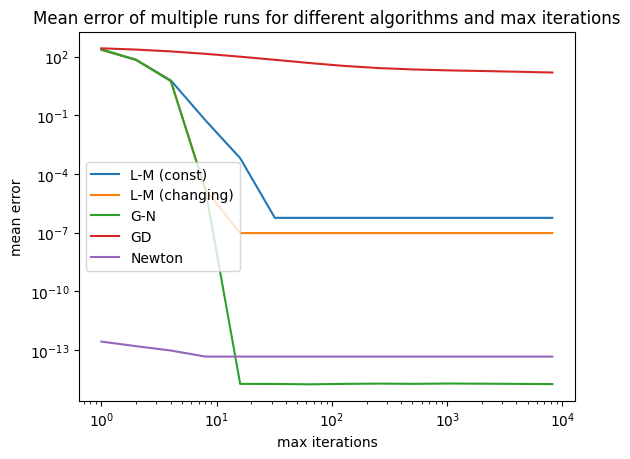

In [ ]:
plt.loglog(max_iters, errors_mean_lm_const, label="L-M (const)")
plt.loglog(max_iters, errors_mean_lm_mod, label="L-M (changing)")
plt.loglog(max_iters, errors_gn_mean, label="G-N")
plt.loglog(max_iters, errors_gd_mean, label="GD")
plt.loglog(max_iters, errors_newton_mean, label="Newton")

plt.legend()
plt.xlabel("max iterations")
plt.ylabel("mean error")
plt.title("Mean error of multiple runs for different algorithms and max iterations")
plt.show()